My last post, about trial-wise acclimation to the task, got me curious about two things: how could I graphically represent individual participants' acclimation to the task, and can I code an efficient way to generate that representation? In total, I have 300 participants across all the experiments, which is a few too many to represent compactly all at once. The best strategy seems to be randomly selecting a few participants from each experiment, and displaying a panel of those samples. An in-depth analysis would probably try to iterate over several such graphs, but with this code in hand, that shouldn't be difficult.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from dissdata import importation

%matplotlib inline

# I find the constant opening and closing of my notebooks very annoying.
# This line ensures that the module gets reloaded every time I run something from it
%autoreload 2
exp = importation()

The goal with this set of graphics is to show onset durations plotted against trial numbers, y and x respectively. I also want to show a very basic linear plot of change over time (trial), so I'll need to generate and then plot a simple linear regression (n.b. the regression setup I used in the actual analysis was significantly more complicated, but this is close enough for now). My overarching goal here was to write some functionality for repeating the basic plotting and random-participant selection, which is functionality I expect to repeat very often. In fact, I wish I'd done this sort of thing years ago - as handy as the typical functions for regression are, a wrapper that makes the process repeatable is far more appealing.

The two functions here get that job done, and then the graph below them presents the basic idea. I select a few participants at random from each experiment (in this case #8), and plot their change over time.

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


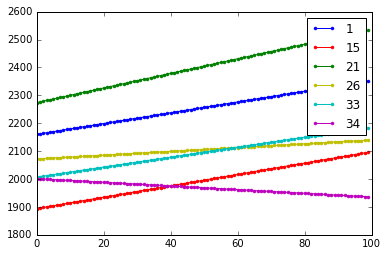

In [67]:
def participant_line(exp, expnum, pnum, xcolumn, ycolumn):
    """This takes an experiment number (1-8), participant number (1-40),
    and two column names (strings), and returns a slope and intercept for
    the linearly-fitted model for those columns. That can then be used in
    the wrapper function to plot the line."""
    subset = exp[expnum][exp[expnum]['subject'] == pnum]
    x = subset[xcolumn]
    y = subset[ycolumn]
    m, b = np.polyfit(x,y,1)
    return(m,b)

def select_participants(expnum,num_participants):
    """There are 36 participants in each of the first four experiments,
    and 40 in each of the latter four, so there are two slightly different
    returns here for selecting a random sample among them.
    
    Although this currently allows you to select the number of participants,
    more than 6 will result in an error, because there aren't enough basic
    colors. This will have to get patched in the next version."""
    if num_participants > 6 or num_participants < 0:
        raise ValueError('Participant # has to be > 0 and <= 7')
    if expnum < 0 or expnum > 8:
        raise ValueError('Experiment # has to be > 0 and <= 8')
    if expnum < 5:
        return sorted(random.sample(range(1,36),num_participants))
    else:
        returnlist = random.sample(range(1,40),num_participants)
        # Experiment 8 doesn't have a 38th participant, for reasons that
        # aren't worth going into. This avoids selecting that number
        if expnum == 8:
            while 38 in returnlist:
                returnlist = random.sample(range(1,40),num_participants)
        return sorted(returnlist)

pnums = select_participants(1,6)
colors = ['b','r','g','y','c','m']
for index, pnum in enumerate(pnums):
    m,b = participant_line(exp.exp,8,pnum,'trial','onset_dur')
    x = range(100)
    plt.plot(x,m*x + b, '-', color = colors[index], marker = '.', label = '%d' %pnum)
plt.legend()

With the individual plots set up like that, the final step is iterating over all 8 experiments and creating a plot for each one, and then tidying up the presentation. The below is the modified function for the plots from earlier posts. Look at how much more compact this is! There are two important differences - one is that the labeling is slightly less complex. Another is that this iterates directly over the subplots, instead of assigning each on a separate line. That condenses dozens of lines of code into 2. Similarly with the labeling, applying text directly to the figure saves ten lines, without losing much if anything in readability.

C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


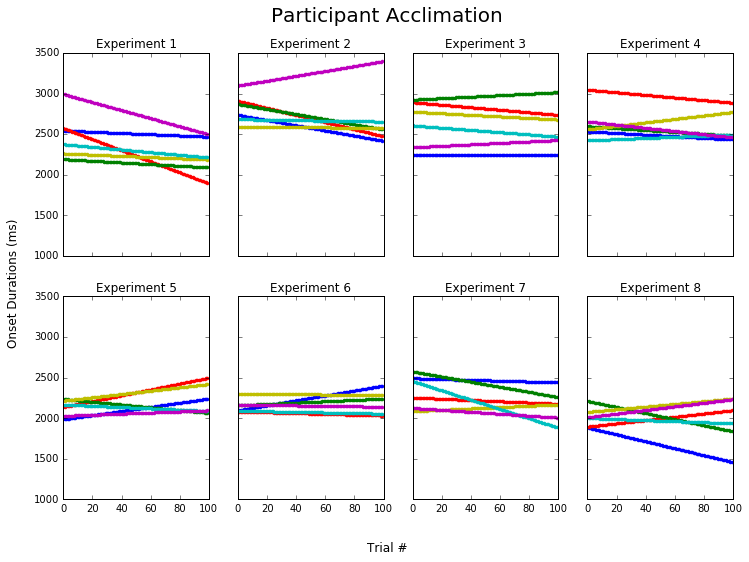

In [66]:
def participant_plots(xcolumn = 'trial',ycolumn = 'onset_dur', title = 'Default Title', xlab = None, ylab = None):
    """Takes an x and y column name and returns a 2x4 plot of a
    random-chosen subset of the participants in the experiments,
    complete with linear regression of y on x."""
    colors = ['b','r','g','y','c','m']
    f, ax = plt.subplots(2,4, sharex = True, sharey = True, figsize = (12,8))
    f.suptitle(title, fontsize = 20)
    for exp_num in range(1,9):
        pnums = select_participants(exp_num,6)
        for index, pnum in enumerate(pnums):
            m,b = participant_line(exp.exp,exp_num,pnum,xcolumn,ycolumn)
            x = range(100)
            f.axes[exp_num-1].plot(x,m*x + b, '-', color = colors[index], marker = '.', label = '%d' %pnum)
            f.axes[exp_num-1].set_title('Experiment %d' %exp_num)
    f.text(0.5, 0.04, xlab, ha = 'center', va = 'center', fontsize = 12)
    f.text(.06, .5, ylab, fontsize = 12, rotation = 'vertical', va = 'center')

participant_plots(title = "Participant Acclimation", ylab = "Onset Durations (ms)", xlab = "Trial #")

What's the takeaway? As in the last post about this, there doesn't seem to be much in the way of systematic acclimation. Some participants do change over the course of the experiment more than others, however. Some by as much as half a second, which is a significant decrease in response time overall. It might therefore be worth further investigation into whether those participants in particular behave differently in other measurement areas. I do not have enough data points to usefully carry out that investigation, sadly. Separating the obviously-acclimating from the less-obviously-acclimating would also present a problem, akin to median-splitting (i.e. you throw away a great deal of possibly-informative variance in favor of an arbitrary distinction).

From a coding perspective, the most important thing to emerge here is the change from assigning information to each subplot separately to iterating and assigning dynamically. I will be integrating this setup as-is into my existing class for plotting my data, and will also be rewriting the old plotting code to capitalize on the new insights.